# Funciones

In [24]:
import os
import json
import copy
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

Funciones para recorrer los mejores runs de cada experimento y guardar sus resultados e hiperparámetros en un diccionario

In [25]:
def obtener_mejores_experimentos(directorio_todos_los_experimentos: str, diccionario_raytune: dict):
    """
    Actualiza el diccionario de resultados de RayTune con los dos mejores experimentos para cada tune,
    añadiendo sus IDs y métricas.

    Parámetros:
    -----------
    directorio_todos_los_experimentos : str
        Ruta base que contiene los experimentos organizados por tune.
    diccionario_raytune : dict
        Diccionario con información de cada tune, que se actualizará con los mejores experimentos.

    Retorno:
    --------
    None
    """
    for tune_number, tune_dict in diccionario_raytune.items():
        path_experimentos = os.path.join(directorio_todos_los_experimentos, tune_number)
        if not os.path.isdir(path_experimentos):
            continue
        procesar_tune(path_experimentos, tune_dict)


def procesar_tune(path_experimentos: str, tune_dict: dict):
    """
    Procesa un directorio de experimentos para un tune específico, actualizando el diccionario de resultados
    con los dos mejores experimentos y sus métricas.

    Parámetros:
    -----------
    path_experimentos : str
        Ruta al directorio que contiene los experimentos para un tune específico.
    tune_dict : dict
        Diccionario con información de un tune, que se actualizará con los mejores experimentos.

    Retorno:
    --------
    None
    """
    for tune_date in os.listdir(path_experimentos):
        complete_path_experimentos = os.path.join(path_experimentos, tune_date)
        try:
            best_experimentos, best_puntaje = retornar_mejores_dos_experimentos(complete_path_experimentos)
            actualizar_diccionario_tune(tune_dict, best_experimentos, best_puntaje)
        except FileNotFoundError:
            continue


def retornar_mejores_dos_experimentos(directorio_experimentos: str) -> tuple:
    """
    Busca y retorna los dos experimentos con los mejores F1 scores en un directorio dado.

    Parámetros:
    -----------
    directorio_experimentos : str
        Ruta al directorio que contiene los experimentos.

    Retorna:
    --------
    tuple
        Un par de tuplas. La primera contiene los IDs de los dos mejores experimentos. 
        La segunda contiene las filas completas de métricas asociadas a los mejores puntajes.
    """
    puntajes = {}
    
    # Iterar sobre los experimentos en el directorio
    for experimento in os.listdir(directorio_experimentos):
        experimento_path = os.path.join(directorio_experimentos, experimento)
    
        if os.path.isdir(experimento_path):
            numero_id = int(experimento.split('_')[3])  # Extraer ID del experimento
            results_path = os.path.join(experimento_path, "progress.csv")
            results = open_results(results_path)
            best_fila = obtener_f1_maximo(results)  # Retorna la fila completa
            puntajes[numero_id] = best_fila  # Guardamos la fila completa
    
    # Ordenar los experimentos por el valor de 'F1_score' en las filas
    llaves_mayores = sorted(puntajes, key=lambda x: puntajes[x]['F1_score'], reverse=True)[:2]
    # Obtener las filas completas (puntajes) correspondientes a esas llaves
    puntajes_mejores = [puntajes[llave] for llave in llaves_mayores]
    return tuple(llaves_mayores), tuple(puntajes_mejores)


def open_results(results_path: str) -> DataFrame:
    """
    Lee el archivo CSV especificado en 'results_path', extrae métricas relevantes 
    y calcula el F1 score basado en precision y recall.

    Parámetros:
    -----------
    results_path : str
        Ruta al archivo 'progress.csv' que contiene los resultados del experimento.

    Retorna:
    --------
    DataFrame
        Un DataFrame con las columnas 'precision', 'recall', 'mAP50', 'mAP50-95' 
        y el F1 score calculado.
    """
    columnas_interes = ['metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
    df = pd.read_csv(results_path)
    # Extraer las columnas específicas y hacer una copia
    datos = df[columnas_interes].copy()
    # Renombrar las columnas eliminando 'metrics/'
    datos = datos.rename(columns=lambda col: col.replace('metrics/', ''))
    # Calcular el F1 score y añadirlo
    datos['F1_score'] = 2 * (datos['precision(M)'] * datos['recall(M)']) / (datos['precision(M)'] + datos['recall(M)'])
    return datos


def obtener_f1_maximo(datos: DataFrame) -> Series:
    """
    Encuentra la fila con el valor máximo de F1 score y retorna todas las columnas 
    asociadas a esa fila.

    Parámetros:
    -----------
    datos : DataFrame
        DataFrame con los resultados de un experimento, incluyendo la columna F1_score.

    Retorna:
    --------
    Series
        Una serie que contiene la fila con el mayor F1 score.
    """
    # Encontrar el índice de la fila con el valor máximo en la columna 'F1_score'
    idx_maximo = datos['F1_score'].idxmax()
    # Retornar todas las columnas asociadas a esa fila
    fila_maxima = datos.loc[idx_maximo]
    return fila_maxima


def actualizar_diccionario_tune(tune_dict: dict, best_experimentos: tuple, best_puntaje: tuple):
    """
    Actualiza el diccionario de resultados de un tune con los IDs de los mejores experimentos y sus métricas.

    Parámetros:
    -----------
    tune_dict : dict
        Diccionario con información de un tune, que se actualizará con los mejores experimentos.
    best_experimentos : tuple
        IDs de los dos mejores experimentos.
    best_puntaje : tuple
        Métricas de los dos mejores experimentos.

    Retorno:
    --------
    None
    """
    tune_dict.update(best=best_experimentos)
    tune_dict.update(score_1=best_puntaje[0], score_2=best_puntaje[1])


def obtener_config(directorio_todos_los_experimentos: str, diccionario_raytune: dict):
    """
    Extrae la configuración de los dos mejores experimentos (definidos por sus IDs en el diccionario de resultados)
    desde un directorio de experimentos y los añade al diccionario `diccionario_raytune`.
    
    Parámetros:
    -----------
    directorio_todos_los_experimentos : str
        La ruta base donde están almacenados los directorios con los resultados de cada "tune".
    diccionario_raytune : dict
        Diccionario que contiene la información sobre los experimentos organizados por "tune".
    
    Retorno:
    --------
    None
    """
    for tune_number, tune_dict in diccionario_raytune.items():
        path_experimentos = os.path.join(directorio_todos_los_experimentos, tune_number)
        if not os.path.isdir(path_experimentos):
            continue
        procesar_tune_para_config(path_experimentos, tune_dict)


def procesar_tune_para_config(path_experimentos: str, tune_dict: dict):
    """
    Procesa un directorio de experimentos para un tune específico y actualiza el diccionario de resultados
    con las configuraciones de los dos mejores experimentos.
    
    Parámetros:
    -----------
    path_experimentos : str
        Ruta al directorio que contiene los experimentos para un tune específico.
    tune_dict : dict
        Diccionario con información de un tune, que se actualizará con las configuraciones
        de los mejores experimentos.
    
    Retorno:
    --------
    None
    """
    for tune_date in os.listdir(path_experimentos):
        try:
            complete_path_experimentos = os.path.join(path_experimentos, tune_date)
            for experimento in os.listdir(complete_path_experimentos):
                procesar_experimento_para_config(complete_path_experimentos, experimento, tune_dict)
        except Exception as e:
            print(f"Error procesando {complete_path_experimentos}: {e}")
            continue

def procesar_experimento_para_config(complete_path_experimentos: str, experimento: str, tune_dict: dict):
    """
    Procesa un experimento específico dentro de un tune y actualiza el diccionario de resultados
    con la configuración si pertenece a los mejores experimentos.
    
    Parámetros:
    -----------
    complete_path_experimentos : str
        Ruta completa al directorio que contiene los experimentos para un tune específico.
    experimento : str
        Nombre del directorio del experimento.
    tune_dict : dict
        Diccionario con información de un tune, que se actualizará con la configuración
        del experimento si es uno de los mejores.
    
    Retorno:
    --------
    None
    """
    experimento_path = os.path.join(complete_path_experimentos, experimento)
    if not os.path.isdir(experimento_path):
        return

    try:
        numero_id = int(experimento.split('_')[3])
        ids = tune_dict.get('best', ())
        if numero_id in ids:
            cargar_y_actualizar_config(experimento_path, tune_dict, numero_id, ids)
    except IndexError as e:
        print(f"Error procesando experimento en {experimento_path}: {e}")
        return

def cargar_y_actualizar_config(experimento_path: str, tune_dict: dict, numero_id: int, ids: tuple):
    """
    Carga la configuración de un experimento específico y actualiza el diccionario de resultados
    si el ID del experimento es uno de los mejores.
    
    Parámetros:
    -----------
    experimento_path : str
        Ruta al directorio del experimento.
    tune_dict : dict
        Diccionario con información de un tune, que se actualizará con la configuración
        del experimento si es uno de los mejores.
    numero_id : int
        ID del experimento.
    ids : tuple
        IDs de los mejores experimentos.
    
    Retorno:
    --------
    None
    """
    params_path = os.path.join(experimento_path, "params.json")
    try:
        with open(params_path, 'r') as archivo:
            params_dict = json.load(archivo)
        if numero_id == ids[0]:
            tune_dict["config1"] = params_dict
        elif numero_id == ids[1]:
            tune_dict["config2"] = params_dict
    except FileNotFoundError:
        print(f"Archivo params.json no encontrado en {experimento_path}")
    except json.JSONDecodeError:
        print(f"Error de decodificación JSON en {params_path}")

Funciones para guardar los resultados en un JSON y usarlos en la siguiente etapa

In [26]:
def guardar_diccionario_como_json(diccionario: dict, archivo_path: str):
    """
    Guarda un diccionario en un archivo JSON después de convertir pandas.Series a diccionarios.

    Parameters:
    -----------
    diccionario : dict
        Diccionario que contiene la información de los experimentos organizados por tune.
    archivo_path : str
        Ruta donde se guardará el archivo JSON.
    
    Returns:
    --------
    None
    """
    diccionario_convertido = convertir_series_a_dict(diccionario)
    with open(archivo_path, 'w') as archivo:
        json.dump(diccionario_convertido, archivo, indent=4)


def convertir_series_a_dict(original_diccionario: dict) -> dict:
    """
    Convierte todas las pandas.Series en el diccionario a diccionarios nativos de Python.
    Parameters:
    -----------
    original_diccionario: dict
        Diccionario que contiene pandas.Series como partes de sus valores.
    Returns:
    --------
    dict
        Nuevo diccionario con pandas.Series convertidas a diccionarios.
    """
    # Crear una copia del diccionario original
    diccionario = copy.deepcopy(original_diccionario)
    
    for key, value in diccionario.items():
        if isinstance(value, pd.Series):
            diccionario[key] = value.to_dict()
        elif isinstance(value, dict):
            diccionario[key] = convertir_series_a_dict(value)
            
    return diccionario

Funciones para visualizar los datos guardados en un Datagrama

In [27]:
def crear_dataframe_experimentos(path_json: str) -> DataFrame:
    """
    Crea un DataFrame a partir de los resultados de experimentos contenidos en un archivo JSON,
    incluyendo métricas y los IDs de los mejores experimentos.

    Parámetros:
    -----------
    path_json : str
        Ruta al archivo JSON que contiene la información de los experimentos organizados por tune.

    Retorna:
    --------
    DataFrame
        DataFrame que contiene el nombre del tune, IDs de los mejores experimentos, y sus métricas.
    """
    resultados = cargar_json_y_convertir_a_series(path_json)
    filas = []

    for tune_number, datos in resultados.items():
        nombre = datos.get('name', tune_number)  # Usamos el nombre o el tune si no está 'name'
        # Obtenemos la tupla de IDs de la llave 'best', si existe, sino NaN
        experimento_ids = datos.get('best', (np.nan, np.nan))
        # Si tiene 'score_1', obtenemos las métricas, sino ponemos NaN
        score_1 = datos.get('score_1', pd.Series(dtype=float)).add_suffix("_1")
        score_2 = datos.get('score_2', pd.Series(dtype=float)).add_suffix("_2")
        # Crear un diccionario para almacenar el nombre, IDs y las métricas
        fila = {'name': nombre, 'Experimentos': experimento_ids}
        fila.update(score_1.to_dict())  # Añadimos las métricas de score_1 al diccionario
        fila.update(score_2.to_dict())  # Añadimos las métricas de score_2 al diccionario
        filas.append(fila)

    # Convertimos la lista de filas a un DataFrame de pandas
    df = pd.DataFrame(filas)
    # Rellenar las columnas vacías con NaN si no tienen datos
    df = df.replace({None: np.nan})
    return df


def cargar_json_y_convertir_a_series(path_json: str) -> dict:
    """
    Carga un archivo JSON que contiene información de experimentos y convierte los diccionarios de
    score en pandas.Series.
    
    Parámetros:
    -----------
    path_json : str
        Ruta al archivo JSON que contiene la información de los experimentos.
    
    Retorna:
    --------
    dict
        Diccionario que contiene la información de los experimentos, con los scores convertidos a pandas.Series.
    """
    with open(path_json, 'r') as archivo:
        diccionario = json.load(archivo)
    
    # Convertir los diccionarios de score en pandas.Series
    for key, value in diccionario.items():
        if 'score_1' in value:
            value['score_1'] = pd.Series(value['score_1'])
        if 'score_2' in value:
            value['score_2'] = pd.Series(value['score_2'])
    
    return diccionario


# Si necesitas usar la función filtrar_metricas también:
def filtrar_metricas(df: DataFrame) -> DataFrame:
    """
    Filtra un DataFrame para incluir únicamente las métricas relevantes ('F1_score', 'mAP50', 'mAP50-95'),
    además de las columnas 'name' y 'Experimentos'.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame que contiene todas las métricas de los experimentos.

    Retorna:
    --------
    DataFrame
        DataFrame filtrado con las métricas relevantes.
    """
    # Seleccionar columnas que contienen 'F1_score', 'mAP50' o 'mAP50-95'
    columnas_interes = df.filter(like='F1_score_1').columns.tolist() + \
                       df.filter(like='mAP50(M)_1').columns.tolist() + \
                       df.filter(like='mAP50-95(M)_1').columns.tolist() + \
                       df.filter(like='F1_score_2').columns.tolist() + \
                       df.filter(like='mAP50(M)_2').columns.tolist() + \
                       df.filter(like='mAP50-95(M)_2').columns.tolist()
    # Filtrar el DataFrame para que contenga las métricas y las columnas 'name' y 'Experimentos'
    df_filtrado = df[['name', 'Experimentos'] + columnas_interes]
    
    return df_filtrado

Diccionarios donde guardar los datos

In [28]:
resultados_raytune_deepfish = {
"tune":   {"name": "Deepfish_yolov8n-seg_AdamW"},
"tune2":  {"name": "Deepfish_yolov8n-seg_SGD"},
"tune3":  {"name": "Deepfish_LO_yolov8n-seg_AdamW"},
"tune4":  {"name": "Deepfish_LO_yolov8n-seg_SGD"},
"tune5":  {"name": "Deepfish_yolov8s-seg_AdamW"},
"tune6":  {"name": "Deepfish_yolov8s-seg_SGD"},
"tune7":  {"name": "Deepfish_LO_yolov8s-seg_AdamW"},
"tune8":  {"name": "Deepfish_LO_yolov8s-seg_SGD"},
"tune9":  {"name": "Deepfish_yolov8m-seg_AdamW"},
"tune10": {"name": "Deepfish_yolov8m-seg_SGD"},
"tune11": {"name": "Deepfish_LO_yolov8m-seg_AdamW"},
"tune12": {"name": "Deepfish_LO_yolov8m-seg_SGD"},
"tune13": {"name": "Deepfish_yolov8l-seg_AdamW"},
"tune14": {"name": "Deepfish_yolov8l-seg_SGD"},
"tune15": {"name": "Deepfish_LO_yolov8l-seg_AdamW"},
"tune16": {"name": "Deepfish_LO_yolov8l-seg_SGD"},
"tune17": {"name": "Deepfish_yolov8x-seg_AdamW"},
"tune18": {"name": "Deepfish_yolov8x-seg_SGD"},
"tune19": {"name": "Deepfish_LO_yolov8x-seg_AdamW"},
"tune20": {"name": "Deepfish_LO_yolov8x-seg_SGD"},
"tune21": {"name": "Deepfish_yolov9c-seg_AdamW"},
"tune22": {"name": "Deepfish_yolov9c-seg_SGD"},
"tune23": {"name": "Deepfish_LO_yolov9c-seg_AdamW"},
"tune24": {"name": "Deepfish_LO_yolov9c-seg_SGD"},
"tune25": {"name": "Deepfish_yolov9e-seg_AdamW"},
"tune26": {"name": "Deepfish_yolov9e-seg_SGD"},
"tune27": {"name": "Deepfish_LO_yolov9e-seg_AdamW"},
"tune28": {"name": "Deepfish_LO_yolov9e-seg_SGD"}
}

resultados_raytune_salmones = {
"tune29":   {"name": "Salmones_yolov8n-seg_AdamW"},
"tune30":  {"name": "Salmones_yolov8n-seg_SGD"},
"tune31":  {"name": "Salmones_LO_yolov8n-seg_AdamW"},
"tune32":  {"name": "Salmones_LO_yolov8n-seg_SGD"},
"tune33":  {"name": "Salmones_yolov8s-seg_AdamW"},
"tune34":  {"name": "Salmones_yolov8s-seg_SGD"},
"tune35":  {"name": "Salmones_LO_yolov8s-seg_AdamW"},
"tune36":  {"name": "Salmones_LO_yolov8s-seg_SGD"},
"tune37":  {"name": "Salmones_yolov8m-seg_AdamW"},
"tune38": {"name": "Salmones_yolov8m-seg_SGD"},
"tune39": {"name": "Salmones_LO_yolov8m-seg_AdamW"},
"tune40": {"name": "Salmones_LO_yolov8m-seg_SGD"},
"tune41": {"name": "Salmones_yolov8l-seg_AdamW"},
"tune42": {"name": "Salmones_yolov8l-seg_SGD"},
"tune43": {"name": "Salmones_LO_yolov8l-seg_AdamW"},
"tune44": {"name": "Salmones_LO_yolov8l-seg_SGD"},
"tune45": {"name": "Salmones_yolov8x-seg_AdamW"},
"tune46": {"name": "Salmones_yolov8x-seg_SGD"},
"tune47": {"name": "Salmones_LO_yolov8x-seg_AdamW"},
"tune48": {"name": "Salmones_LO_yolov8x-seg_SGD"},
"tune49": {"name": "Salmones_yolov9c-seg_AdamW"},
"tune50": {"name": "Salmones_yolov9c-seg_SGD"},
"tune51": {"name": "Salmones_LO_yolov9c-seg_AdamW"},
"tune52": {"name": "Salmones_LO_yolov9c-seg_SGD"},
"tune53": {"name": "Salmones_yolov9e-seg_AdamW"},
"tune54": {"name": "Salmones_yolov9e-seg_SGD"},
"tune55": {"name": "Salmones_LO_yolov9e-seg_AdamW"},
"tune56": {"name": "Salmones_LO_yolov9e-seg_SGD"}
}

Funciones para visualizar datos con gráficos

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


def combine_datagrams(datagrams):
    combined_df = pd.DataFrame()

    for df in datagrams:
        # Crear una copia del DataFrame para evitar el warning
        df_copy = df.copy()
        
        # Eliminar la columna "Experimentos"
        if "Experimentos" in df_copy.columns:
            df_copy.drop(columns=["Experimentos"], inplace=True)
        
        # Juntar las columnas de métricas
        melted_df = pd.DataFrame()
        
        for col in ['F1_score', 'mAP50(M)', 'mAP50-95(M)']:
            values_col1 = df_copy[f'{col}_1']
            values_col2 = df_copy[f'{col}_2']
            
            concatenated_values = pd.concat([values_col1, values_col2], ignore_index=True)
            melted_df = pd.concat([melted_df, concatenated_values.rename(col)], axis=1)
        
        # Crear columnas 'Dataset', 'Model', 'Optimizer' a partir de 'name'
        dataset_list = []
        model_list = []
        optimizer_list = []

        for name in pd.concat([df_copy['name']] * 2, ignore_index=True):
            name_parts = name.split('_')
            dataset_name = '_'.join(name_parts[:-2])
            model_name = name_parts[-2]
            optimizer = name_parts[-1]
            
            dataset_list.append(dataset_name)
            model_list.append(model_name)
            optimizer_list.append(optimizer)

        # Añadir las nuevas columnas
        melted_df['Dataset'] = dataset_list
        melted_df['Model'] = model_list
        melted_df['Optimizer'] = optimizer_list

        # Agregar al DataFrame combinado
        if combined_df.empty:
            combined_df = melted_df
        else:
            combined_df = pd.concat([combined_df, melted_df], ignore_index=True)
    
    return combined_df[['Dataset', 'Model', 'Optimizer', 'F1_score', 'mAP50(M)', 'mAP50-95(M)']]


def plot_metric(datagrams, metric, group_by, labels):
    # Asegurarse de que la longitud de las etiquetas coincida con el número de datagramas
    if len(datagrams) != len(labels):
        raise ValueError("El número de etiquetas debe coincidir con el número de datagramas.")
    
    # Definir el orden de los modelos de más pequeño a más grande
    model_order = ["yolov8n-seg", "yolov8s-seg", "yolov8m-seg", "yolov9c-seg", "yolov8l-seg", "yolov9e-seg", "yolov8x-seg"]
    optimizer_order = ["AdamW", "SGD"]

    if group_by == 'Model':
        order = model_order
        xlabel = 'Modelo'
    elif group_by == 'Optimizer':
        order = optimizer_order
        xlabel = 'Optimizador'
    elif group_by == 'Dataset':
        # Leer los datasets únicos desde todos los datagramas
        dataset_order = pd.concat([df['Dataset'] for df in datagrams]).dropna().unique()
        order = dataset_order
        xlabel = 'Dataset'
    else:
        raise ValueError("group_by debe ser uno de 'Model', 'Optimizer', o 'Dataset'")

    # Crear la figura
    plt.figure(figsize=(8, 4))

    # Definir una lista de colores para las curvas
    colors = sns.color_palette("hls", len(datagrams))

    # Iterar sobre los datagramas y plotear sus datos
    for i, (df, label) in enumerate(zip(datagrams, labels)):
        # Filtrar las filas que tengan NaN en la métrica seleccionada
        df_filtered = df.dropna(subset=[metric])

        # Crear el scatter plot con barras de dispersión
        sns.stripplot(x=group_by, y=metric, data=df_filtered, order=order, jitter=True, marker='o', alpha=0.6, color=colors[i])

        # Calcular los promedios
        means = df_filtered.groupby(group_by)[metric].mean().reindex(order)

        # Plotear la curva de los promedios
        plt.plot(order, means, marker='o', color=colors[i], label=label)

    # Configuración del gráfico
    plt.xlabel(xlabel)
    plt.ylabel(metric.replace('_', ' '))
    plt.title(f'Rendimiento del {metric.replace("_", " ")} por {xlabel}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Deepfish

Llenar el diccionario con los resultados del entrenamiento con Raytune y guardarlos en un archivo JSON

In [30]:
obtener_mejores_experimentos("runs/detect", resultados_raytune_deepfish)
obtener_config("runs/detect", resultados_raytune_deepfish)
guardar_diccionario_como_json(resultados_raytune_deepfish, 'tuning/resultados_raytune_deepfish_4_2.json')

## Visualizar los mejores runs de cada experimento como una tabla

### Resultados con ("single_cls": False, "cos_lr": False)

In [31]:
path_json = 'tuning/resultados_raytune_deepfish_1.json'
dataframe_deepfish_1 = crear_dataframe_experimentos(path_json)
df_deep_1 = filtrar_metricas(dataframe_deepfish_1)
df_deep_1.index = range(1, len(df_deep_1) + 1)
df_deep_1.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.973801,0.980280,0.793480,0.973264,0.974080,0.773310
2,Deepfish_yolov8n-seg_SGD,0.973858,0.981151,0.744352,0.973779,0.989280,0.731980
3,Deepfish_LO_yolov8n-seg_AdamW,0.967304,0.976192,0.771690,0.966654,0.964890,0.721740
4,Deepfish_LO_yolov8n-seg_SGD,0.979969,0.973320,0.746780,0.977824,0.974700,0.706960
5,Deepfish_yolov8s-seg_AdamW,0.992963,0.991320,0.784720,0.980175,0.979000,0.780300
6,Deepfish_yolov8s-seg_SGD,0.986763,0.985330,0.781130,0.978976,0.986560,0.729320
7,Deepfish_LO_yolov8s-seg_AdamW,0.990327,0.987390,0.797730,0.986099,0.984470,0.813850
8,Deepfish_LO_yolov8s-seg_SGD,0.990488,0.985707,0.785524,0.973359,0.969550,0.755630
9,Deepfish_yolov8m-seg_AdamW,0.975251,0.980680,0.770250,0.973208,0.978980,0.801610
10,Deepfish_yolov8m-seg_SGD,0.979175,0.976400,0.792070,0.973864,0.989370,0.805380


In [32]:
path_json = 'tuning/resultados_raytune_deepfish_1_2.json'
dataframe_deepfish_1_2 = crear_dataframe_experimentos(path_json)
df_deep_1_2 = filtrar_metricas(dataframe_deepfish_1_2)
df_deep_1_2.index = range(1, len(df_deep_1_2) + 1)
df_deep_1_2.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.980409,0.991150,0.786490,0.974001,0.97205,0.773340
2,Deepfish_yolov8n-seg_SGD,0.973726,0.982150,0.760730,0.973285,0.96888,0.752490
3,Deepfish_LO_yolov8n-seg_AdamW,0.974420,0.977590,0.774370,0.971641,0.98287,0.752340
4,Deepfish_LO_yolov8n-seg_SGD,0.980831,0.984260,0.740870,0.964306,0.98211,0.744090
5,Deepfish_yolov8s-seg_AdamW,0.980308,0.985177,0.822206,0.979410,0.97074,0.758160
6,Deepfish_yolov8s-seg_SGD,0.986762,0.985040,0.784130,0.978971,0.98963,0.795840
7,Deepfish_LO_yolov8s-seg_AdamW,0.979733,0.975650,0.788690,0.979222,0.98027,0.794080
8,Deepfish_LO_yolov8s-seg_SGD,0.972873,0.974120,0.771860,0.972659,0.98728,0.788070
9,Deepfish_yolov8m-seg_AdamW,0.979945,0.973660,0.798740,0.974360,0.97101,0.754320
10,Deepfish_yolov8m-seg_SGD,0.980128,0.983440,0.781270,0.979762,0.97532,0.786320


### Resultados con ("single_cls": False, "cos_lr": True)

In [33]:
path_json = 'tuning/resultados_raytune_deepfish_2.json'
dataframe_deepfish_2 = crear_dataframe_experimentos(path_json)
df_deep_2 = filtrar_metricas(dataframe_deepfish_2)
df_deep_2.index = range(1, len(df_deep_2) + 1)
df_deep_2.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.979868,0.975380,0.765590,0.978638,0.975910,0.779530
2,Deepfish_yolov8n-seg_SGD,0.973654,0.975270,0.744760,0.973477,0.978940,0.755950
3,Deepfish_LO_yolov8n-seg_AdamW,0.972721,0.982550,0.752210,0.970437,0.986550,0.739920
4,Deepfish_LO_yolov8n-seg_SGD,0.980508,0.976160,0.760660,0.979810,0.983830,0.742140
5,Deepfish_yolov8s-seg_AdamW,0.980599,0.979890,0.753180,0.978500,0.976470,0.757170
6,Deepfish_yolov8s-seg_SGD,0.979998,0.970690,0.782040,0.973980,0.976460,0.779630
7,Deepfish_LO_yolov8s-seg_AdamW,0.979931,0.983790,0.797420,0.979555,0.974640,0.783420
8,Deepfish_LO_yolov8s-seg_SGD,0.973575,0.984520,0.783270,0.972842,0.986060,0.776350
9,Deepfish_yolov8m-seg_AdamW,0.980325,0.987940,0.792350,0.973116,0.967253,0.788411
10,Deepfish_yolov8m-seg_SGD,0.979931,0.985200,0.805870,0.979644,0.985960,0.776250


In [34]:
path_json = 'tuning/resultados_raytune_deepfish_2_2.json'
dataframe_deepfish_2_2 = crear_dataframe_experimentos(path_json)
df_deep_2_2 = filtrar_metricas(dataframe_deepfish_2_2)
df_deep_2_2.index = range(1, len(df_deep_2_2) + 1)
df_deep_2_2.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.973861,0.949630,0.757110,0.972889,0.96968,0.77827
2,Deepfish_yolov8n-seg_SGD,0.965765,0.974180,0.732990,0.965515,0.95871,0.75408
3,Deepfish_LO_yolov8n-seg_AdamW,0.979300,0.988530,0.764710,0.974093,0.97755,0.75525
4,Deepfish_LO_yolov8n-seg_SGD,0.978499,0.977815,0.763604,0.965840,0.97384,0.71644
5,Deepfish_yolov8s-seg_AdamW,0.986752,0.986280,0.811530,0.979946,0.97778,0.75323
6,Deepfish_yolov8s-seg_SGD,0.979110,0.971701,0.807531,0.977431,0.98557,0.78271
7,Deepfish_LO_yolov8s-seg_AdamW,0.979774,0.969080,0.774920,0.979497,0.97829,0.73627
8,Deepfish_LO_yolov8s-seg_SGD,0.973903,0.990050,0.779570,0.967274,0.98285,0.76419
9,Deepfish_yolov8m-seg_AdamW,0.993526,0.986630,0.788500,0.978194,0.98537,0.78124
10,Deepfish_yolov8m-seg_SGD,0.992007,0.994630,0.782280,0.984980,0.97679,0.79425


### Resultados con ("single_cls": True, "cos_lr": False)

In [35]:
path_json = 'tuning/resultados_raytune_deepfish_3.json'
dataframe_deepfish_3 = crear_dataframe_experimentos(path_json)
df_deep_3 = filtrar_metricas(dataframe_deepfish_3)
df_deep_3.index = range(1, len(df_deep_3) + 1)
df_deep_3.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.975377,0.980650,0.763490,0.973304,0.979699,0.762023
2,Deepfish_yolov8n-seg_SGD,0.967592,0.986030,0.734720,0.965521,0.963400,0.742120
3,Deepfish_LO_yolov8n-seg_AdamW,0.979803,0.990340,0.762690,0.972388,0.969070,0.735190
4,Deepfish_LO_yolov8n-seg_SGD,0.966277,0.982620,0.754590,0.966187,0.973390,0.721190
5,Deepfish_yolov8s-seg_AdamW,0.987102,0.988335,0.798456,0.986408,0.979110,0.818240
6,Deepfish_yolov8s-seg_SGD,0.980076,0.983610,0.803140,0.976980,0.988056,0.820088
7,Deepfish_LO_yolov8s-seg_AdamW,0.978294,0.984250,0.768910,0.971697,0.976570,0.767400
8,Deepfish_LO_yolov8s-seg_SGD,0.977640,0.985720,0.782170,0.972799,0.987250,0.747130
9,Deepfish_yolov8m-seg_AdamW,0.980147,0.967340,0.777980,0.974650,0.987020,0.770600
10,Deepfish_yolov8m-seg_SGD,0.980110,0.994020,0.810350,0.979649,0.968900,0.778520


In [36]:
path_json = 'tuning/resultados_raytune_deepfish_3_2.json'
dataframe_deepfish_3_2 = crear_dataframe_experimentos(path_json)
df_deep_3_2 = filtrar_metricas(dataframe_deepfish_3_2)
df_deep_3_2.index = range(1, len(df_deep_3_2) + 1)
df_deep_3_2.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.980284,0.978790,0.765690,0.979394,0.967280,0.760400
2,Deepfish_yolov8n-seg_SGD,0.966497,0.970710,0.738780,0.960399,0.984206,0.749669
3,Deepfish_LO_yolov8n-seg_AdamW,0.976896,0.982260,0.747470,0.972280,0.976350,0.753160
4,Deepfish_LO_yolov8n-seg_SGD,0.974311,0.978820,0.770310,0.960953,0.979407,0.752455
5,Deepfish_yolov8s-seg_AdamW,0.984348,0.983320,0.786660,0.973486,0.989860,0.800460
6,Deepfish_yolov8s-seg_SGD,0.979316,0.991500,0.802850,0.978033,0.984680,0.799570
7,Deepfish_LO_yolov8s-seg_AdamW,0.973842,0.978850,0.748110,0.973153,0.965340,0.745780
8,Deepfish_LO_yolov8s-seg_SGD,0.975417,0.993000,0.787388,0.973553,0.973420,0.774760
9,Deepfish_yolov8m-seg_AdamW,0.980673,0.976370,0.799270,0.980154,0.982700,0.786050
10,Deepfish_yolov8m-seg_SGD,0.980065,0.986250,0.757280,0.961201,0.977380,0.735290


### Resultados con ("single_cls": True, "cos_lr": True)

In [37]:
path_json = 'tuning/resultados_raytune_deepfish_4.json'
dataframe_deepfish_4 = crear_dataframe_experimentos(path_json)
df_deep_4 = filtrar_metricas(dataframe_deepfish_4)
df_deep_4.index = range(1, len(df_deep_4) + 1)
df_deep_4.drop(columns="Experimentos")

,name,F1_score_1,mAP50(M)_1,mAP50-95(M)_1,F1_score_2,mAP50(M)_2,mAP50-95(M)_2
1,Deepfish_yolov8n-seg_AdamW,0.979617,0.97767,0.777130,0.973971,0.977300,0.774970
2,Deepfish_yolov8n-seg_SGD,0.973116,0.97031,0.737320,0.972862,0.968150,0.705050
3,Deepfish_LO_yolov8n-seg_AdamW,0.978290,0.97685,0.720160,0.972837,0.963890,0.738890
4,Deepfish_LO_yolov8n-seg_SGD,0.973654,0.97205,0.735190,0.966458,0.977090,0.740380
5,Deepfish_yolov8s-seg_AdamW,0.993615,0.98793,0.811400,0.974292,0.982220,0.781180
6,Deepfish_yolov8s-seg_SGD,0.983915,0.98335,0.800800,0.973480,0.980150,0.765930
7,Deepfish_LO_yolov8s-seg_AdamW,0.991778,0.98600,0.815030,0.980549,0.981260,0.765620
8,Deepfish_LO_yolov8s-seg_SGD,0.986109,0.99363,0.773470,0.984652,0.990550,0.773190
9,Deepfish_yolov8m-seg_AdamW,0.981315,0.98627,0.794750,0.980523,0.974730,0.783030
10,Deepfish_yolov8m-seg_SGD,0.985981,0.98037,0.808660,0.985821,0.993260,0.796070


In [38]:
path_json = 'tuning/resultados_raytune_deepfish_4_2.json'
dataframe_deepfish_4_2 = crear_dataframe_experimentos(path_json)
df_deep_4_2 = filtrar_metricas(dataframe_deepfish_4_2)
df_deep_4_2.index = range(1, len(df_deep_4_2) + 1)
df_deep_4_2.drop(columns="Experimentos")

## Visualizar con gráficos el efecto de distintos hiperparámetros y otras cosas.

In [39]:
# Crear datagramas reformateados
datagram_list = [df_deep_1, df_deep_1_2, df_deep_2, df_deep_2_2, df_deep_3, df_deep_3_2, df_deep_4, df_deep_4_2]
combined_1 = combine_datagrams([df_deep_1, df_deep_1_2])
combined_2 = combine_datagrams([df_deep_2, df_deep_2_2])
combined_3 = combine_datagrams([df_deep_3, df_deep_3_2])
combined_4 = combine_datagrams([df_deep_4, df_deep_4_2])
combined_df = combine_datagrams(datagram_list)
combined_df

,Dataset,Model,Optimizer,F1_score,mAP50(M),mAP50-95(M)
0,Deepfish,yolov8n-seg,AdamW,0.973801,0.980280,0.793480
1,Deepfish,yolov8n-seg,SGD,0.973858,0.981151,0.744352
2,Deepfish_LO,yolov8n-seg,AdamW,0.967304,0.976192,0.771690
3,Deepfish_LO,yolov8n-seg,SGD,0.979969,0.973320,0.746780
4,Deepfish,yolov8s-seg,AdamW,0.992963,0.991320,0.784720
...,...,...,...,...,...,...
387,Deepfish_LO,yolov9c-seg,SGD,0.987105,0.993390,0.792740
388,Deepfish,yolov9e-seg,AdamW,0.986688,0.990175,0.815020
389,Deepfish,yolov9e-seg,SGD,0.986623,0.988320,0.808300
390,Deepfish_LO,yolov9e-seg,AdamW,0.974335,0.977413,0.797551


In [40]:
labels_1 = ["Promedio total"]
labels_2 = ["single_cls=False y cos_lr=False", "single_cls=False y cos_lr=True", "single_cls=True y cos_lr=False", "single_cls=True y cos_lr=True"]

### Sacar conclusiones sobre que efecto tienen el tamaño de modelo, optimizador y tipo de dataset.

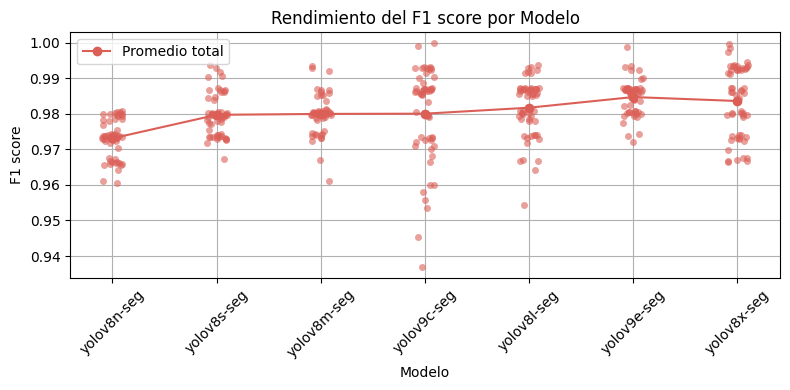

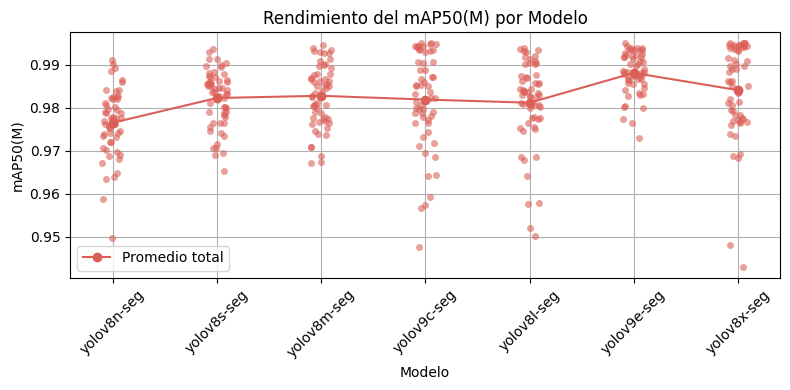

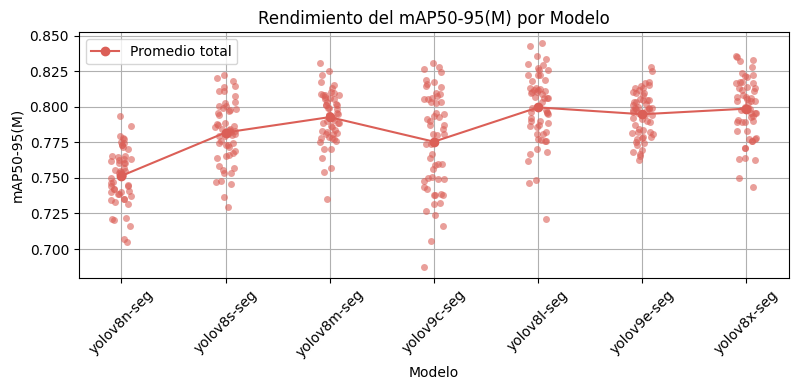

In [41]:
# Llamar a la función de plot para una métrica específica
plot_metric([combined_df], 'F1_score', 'Model', labels_1)
plot_metric([combined_df], 'mAP50(M)', 'Model', labels_1)
plot_metric([combined_df], 'mAP50-95(M)', 'Model', labels_1)

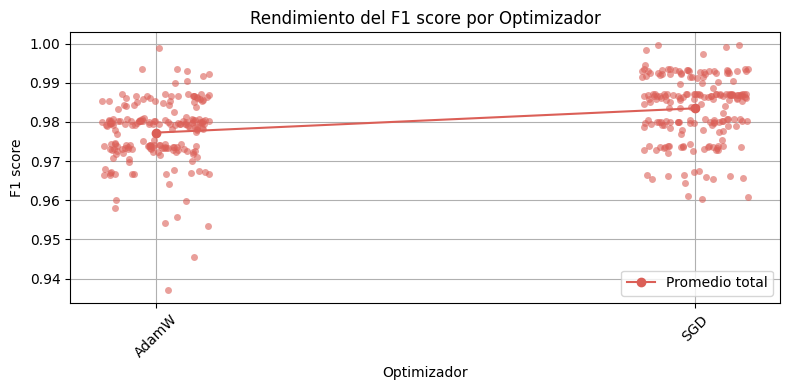

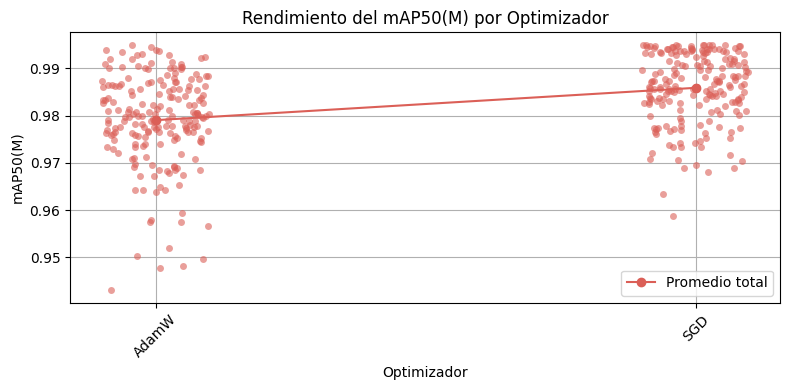

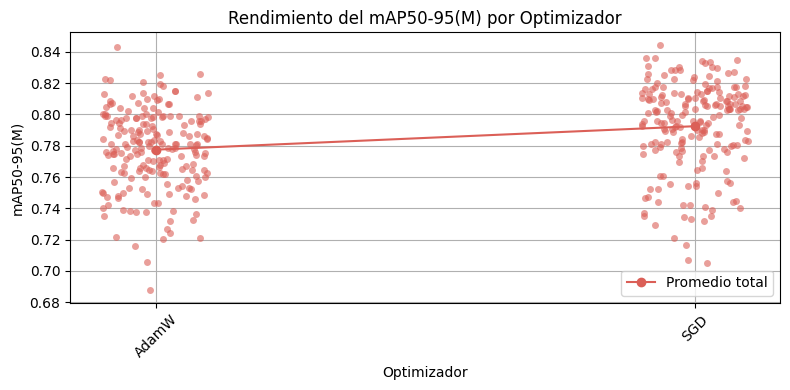

In [42]:
# Llamar a la función de plot para una métrica específica
plot_metric([combined_df], 'F1_score', 'Optimizer', labels_1)
plot_metric([combined_df], 'mAP50(M)', 'Optimizer', labels_1)
plot_metric([combined_df], 'mAP50-95(M)', 'Optimizer', labels_1)

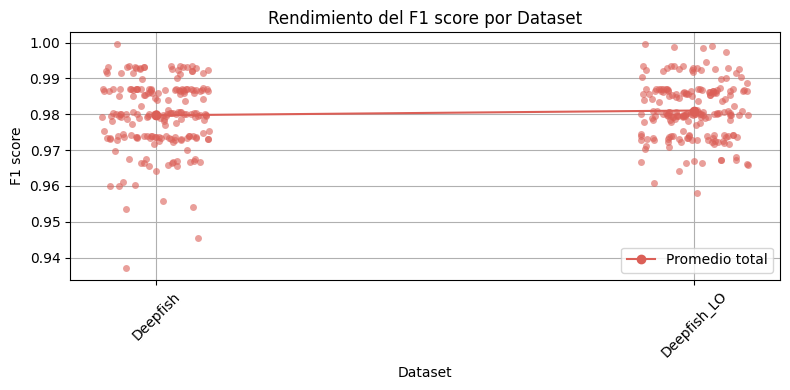

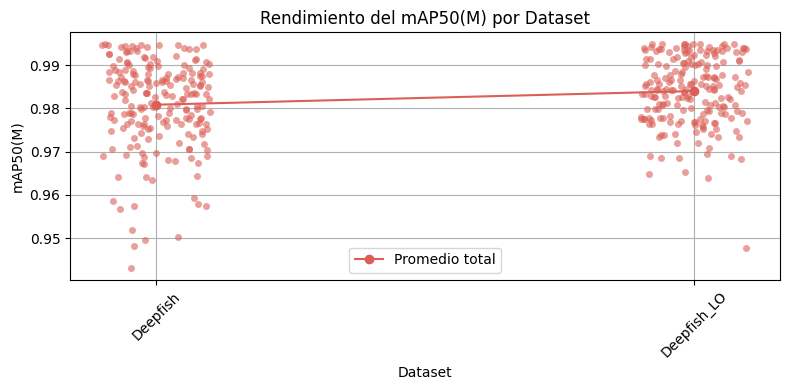

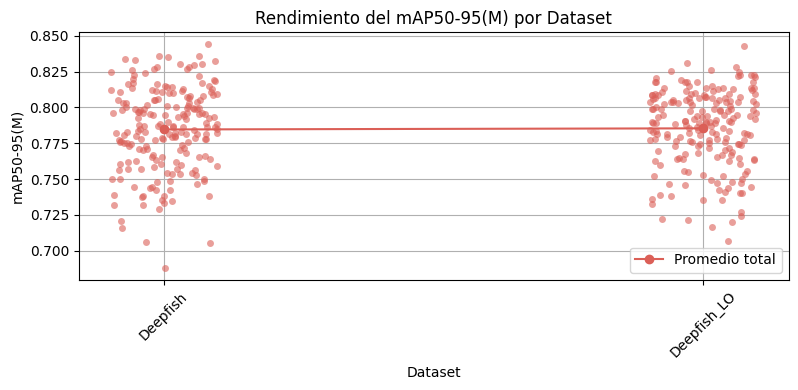

In [43]:
# Llamar a la función de plot para una métrica específica
plot_metric([combined_df], 'F1_score', 'Dataset', labels_1)
plot_metric([combined_df], 'mAP50(M)', 'Dataset', labels_1)
plot_metric([combined_df], 'mAP50-95(M)', 'Dataset', labels_1)

### Sacar concluciones sobre si conviene o no usar ("single_cls": True, "cos_lr": True)

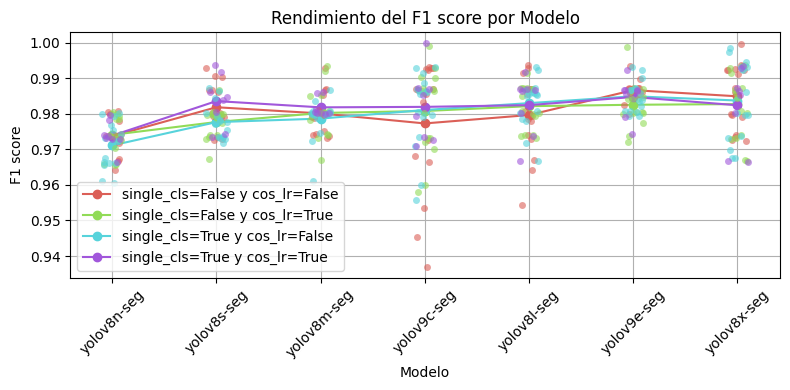

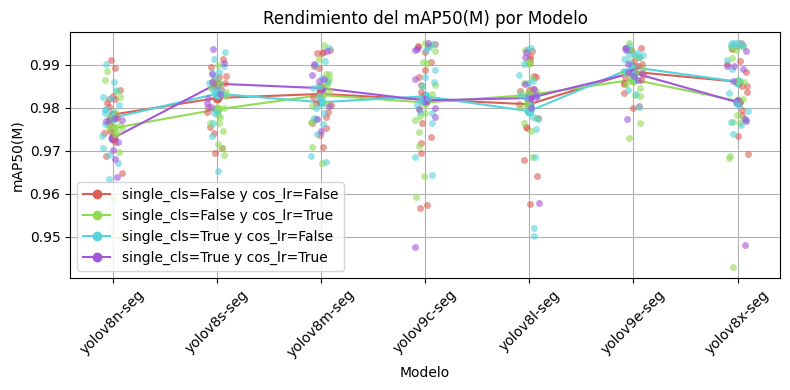

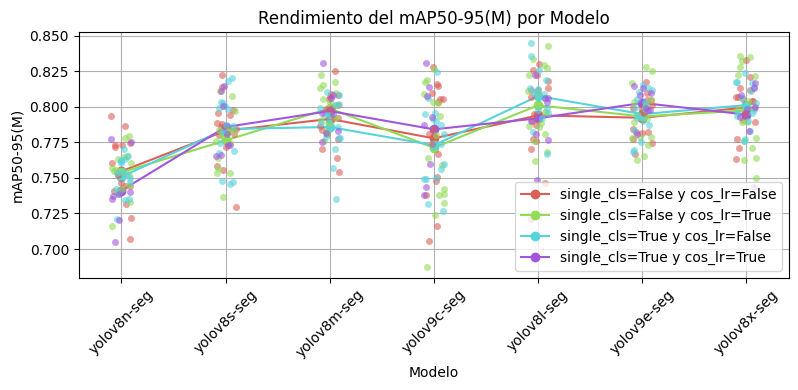

In [44]:
plot_metric([combined_1, combined_2, combined_3, combined_4], 'F1_score', 'Model', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50(M)', 'Model', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50-95(M)', 'Model', labels_2)

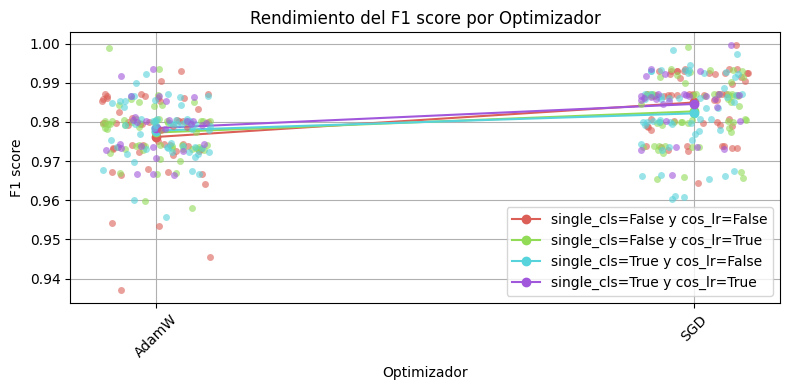

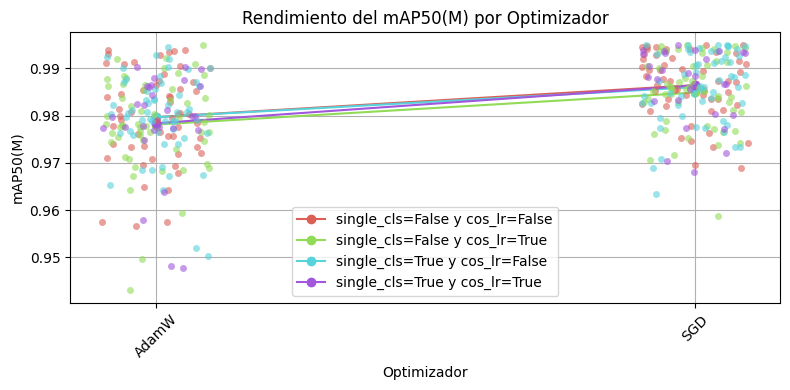

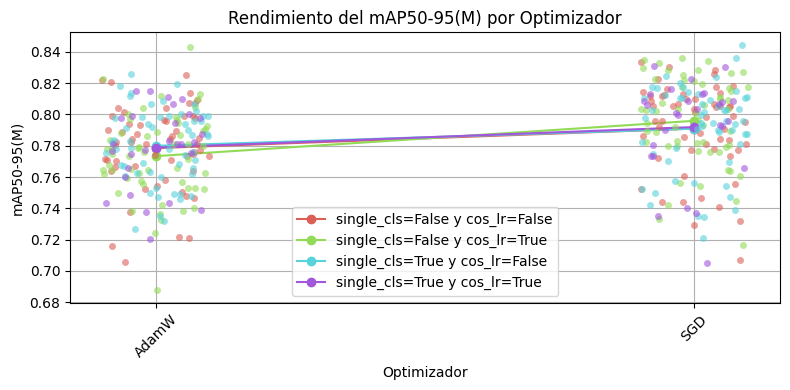

In [45]:
plot_metric([combined_1, combined_2, combined_3, combined_4], 'F1_score', 'Optimizer', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50(M)', 'Optimizer', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50-95(M)', 'Optimizer', labels_2)

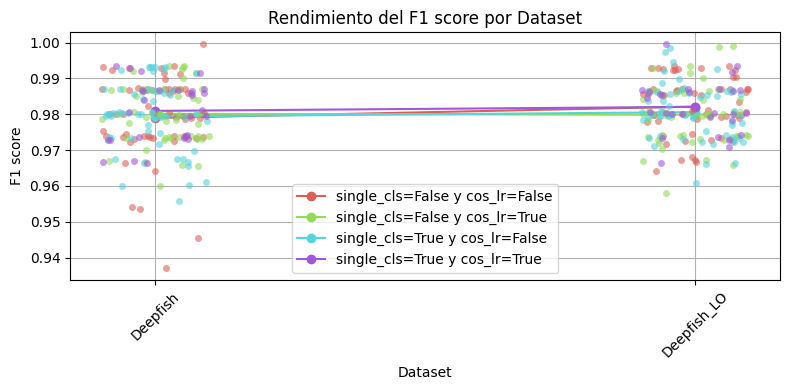

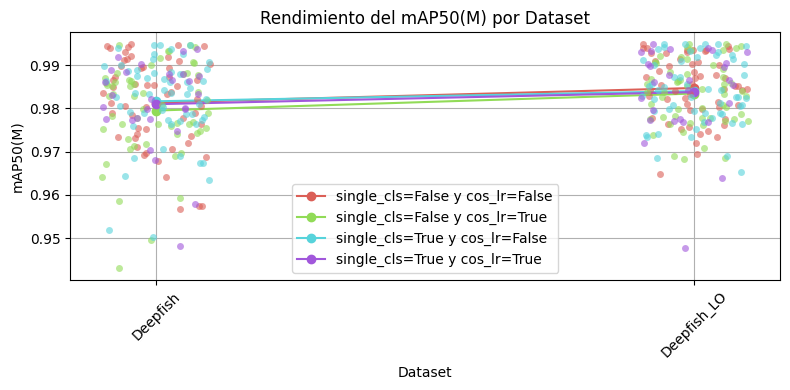

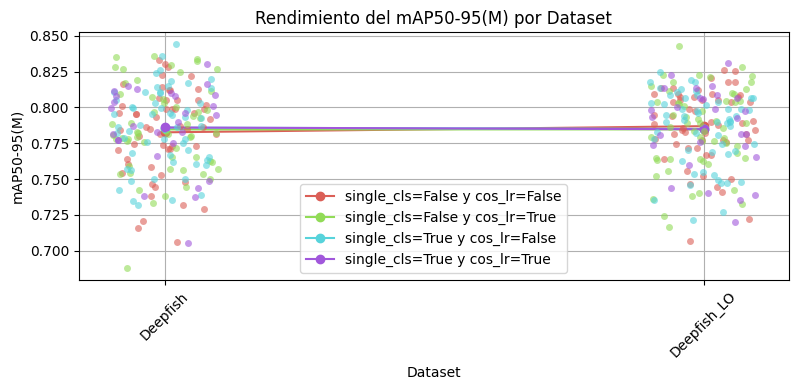

In [46]:
plot_metric([combined_1, combined_2, combined_3, combined_4], 'F1_score', 'Dataset', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50(M)', 'Dataset', labels_2)
plot_metric([combined_1, combined_2, combined_3, combined_4], 'mAP50-95(M)', 'Dataset', labels_2)

## Conclusiones Deepfish

- Referete al modelo:
    - Parece claro que para el dataset Deepfish el tamaño del modelo tiene relevancia pues yolov8-n es muy pequeño y no alcanza los mejores resultados de validación pero a partir de modelos más grandes no es muy relevante cual se utilice ya que las diferencias varian poco.
    - Tambien parece ser que el modelo yolov9-e converge mejor puesto que los resultados están más concentrados y menos dispersos, osea que alcanzan buenos entrenamientos independiente de los hiperparámetros, igualmente los de yolov9-c son los más dispersos. Es posible que la naturaleza de yolov9 permita más variedad de resultados pero al hacerse transfer learning con la version de tamaño grande (E) es que su varizción es pequeña ya que se están entrenando pocos pesos. De ser así Yolov9 tiene peor convergencia pero al realizar transfer learning se consigue una convergencia más consistente a costa de un poco de rendimiento y calidad.
    - Cabe preguntarse si yolov9-e es capaz de conseguir mejores resultados si se le aplica transfer learning + fine tuning o si se le aplica un entrenamiento completo sin congelar capas. (posible trabajo para la parte 2)

- Referente al optimizador:
    - No cabe la menor duda que el uso de SGD permite en promedio mejores resultados de forma muy consistente para todos los casos. Aún así la diferencia es mínima pero esto puede deberse a que en general, con el dataset de Deepfish, todos los resultados son muy buneos así que cualquier mejora es difícil de diferenciar. Aún así si se pudiera justificar los resultados con SGD es que este es menos sensible al learning_rate, por lo tanto se adapta y mejora una buena convergencia independiente de sus hiperparámetros, AdamW por otro lado es más dependiente y por ende en la busqueda realizada con Raytune es menos probable toparse con casos de buena convergencia, por lo tanto sus mejores 2 runs son en promedioa a lo largo de todos los experimentos, un poco inferiores.

- Referente al retiro de imagenes de backgrouds (Labels Only):
    - Para las métricas F1-score y mAP50, el retiro de imagenes de fondo permitió un entrenamiento con mejores resultados de validación.
    - Para la métrica mAP50-95, el retiro de imagenes de fondo no conlleva ninguna diferencia sino una minuscula caida en los resultados de validación.
    - El porque de la mejora puede deberse a que las imagenes de fondos son "redundantes", debido a como está diseñado el dataset de Deepfish, las imagenes están por escenas y cada escena posee multiples imagenes con y sin peces por ende las sin peces sobran pues esta características del fondo pueden ser entendidos observando solamente las imagenes con peces, por ende al realizar backward propagation y el calculo de la loss function estas se promedian entre todas las imagenes de los lotes, entocnes al haber imagenes de más (en este caso las de fondo) que no son ricas en información, la caracterización en los parámtros de "diluye" y vuelve menor. Además hay que añadir que el dataset de validación de Deepfish es similar a su dataset de entrenamiento y por ende la información de fondos nunca llega a ser relevante. No podemos concluir que será igual con el dataset de Salmones.

- Referente a hiperparámetros single_class y cos_lr:
    - Parece ser que no causan mayores diferencias, no se distingue que ninguno otorogue una ventaja sobre no utilizarlo. Mas en teoría el uso de single_class debiese mejorar ligeramente el rendimiento del modelo y cos_lr debiese permitir una mejor convergencia.
    - Si bien no se nota una mejora clara debido a que el problema es lo suficientemente sencillo para siempre alcanzar puntajes de validación muy altas, aún así se preferirá el uso de estos hiperparámetros ante la alternativa de no usarlos.

# Salmones

Llenar el diccionario con los resultados del entrenamiento con Raytune

In [24]:
obtener_mejores_experimentos("runs/detect", resultados_raytune_salmones)
obtener_config("runs/detect", resultados_raytune_salmones)
guardar_diccionario_como_json(resultados_raytune_salmones, 'resultados_raytune_salmones.json')

Visualizar los mejores runs de cada experimento como una tabla

In [ ]:
dataframe_salmones = crear_dataframe_experimentos(resultados_raytune_salmones)
df_salm = filtrar_metricas(dataframe_salmones)
df_salm.index = range(1, len(df_salm) + 1)
df_salm